In [55]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import glob as gb

%matplotlib inline

In [56]:
from scipy.optimize import curve_fit

def mono_exp_decay(t, a, tau, c):
    """ Mono-exponential decay function. t is the time."""
    return a * np.exp(-t / tau) + c


def fit_decay(t, y):
    """ Function to fit the data, y, to the mono-exponential decay."""
    # Guess initial fitting parameters
    a_guess = max(y) - min(y)

    y_norm = y - min(y)
    y_norm = y_norm / max(y_norm)
    t_loc = np.where(y_norm <= 1/np.e)
    tau_guess = t[t_loc[0][0]]

    c_guess = min(y)
    # Fit decay
    popt, pcov = curve_fit(mono_exp_decay, t, y, p0=(a_guess, tau_guess, c_guess))
    return popt

In [60]:
import os
# Get list of folders
folders = max(gb.iglob("Data/*"), key=os.path.getctime)
folders

'Data\\1464190915.758261'

In [61]:
os.path(folders)

TypeError: 'module' object is not callable

In [ ]:
folders

In [48]:
df = pd.DataFrame()

# for folder in folders:
for file in gb.glob(folders[0] + '/raw/*.h5'):
#     print(file)
    
    # Load HDF file
    store = pd.HDFStore(file)
    
    df_file = store['log']
    
    # Create time axis in ms
    fs = store['log']['fs'][0]
    samples = store['log']['sample_no'][0]

    x = np.arange(samples) * fs * 1E3
    
    # Load decay data
    y = store['data']
    
    # Calculate lifetime
    popt = fit_decay(x, y)
    tau = popt[1]
    
    # Append lifetime to dataframe
    df_file['tau'] = tau
    
    # Add sweep data to measurement dataframe
    df = df.append(df_file)
    
    # Close hdf5 file
    store.close()
    
# Sort rows by datetime
df = df.set_index('datetime').sort_index()
df = df.reset_index()
df.head()

,datetime,chip,concentration,fs,humidity,medium,sample_no,sweep_no,sweeps,tempC,timeID,tau
0,2016-05-25 15:20:05.792427,T16,NaN,0.0001,32.99,Air,1000,1,10000,24.94,1.464186e+09,10.686287
1,2016-05-25 15:20:06.050442,T16,NaN,0.0001,32.99,Air,1000,2,10000,24.94,1.464186e+09,10.682954
2,2016-05-25 15:20:06.264454,T16,NaN,0.0001,32.99,Air,1000,3,10000,24.94,1.464186e+09,10.701334
3,2016-05-25 15:20:06.414463,T16,NaN,0.0001,32.99,Air,1000,4,10000,24.94,1.464186e+09,10.673838
4,2016-05-25 15:20:06.564471,T16,NaN,0.0001,32.99,Air,1000,5,10000,24.94,1.464186e+09,10.684255


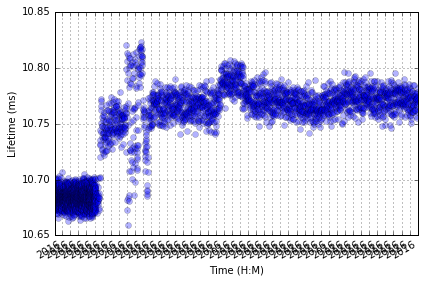

In [52]:
fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)
# ax.plot(df['datetime'], df['tempC'], '-')

# format the ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 10)))

ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Time (H:M)')
plt.ylabel('Lifetime (ms)')
plt.tight_layout()

plt.savefig(folders[0] + '/lifetimeVsTime.png', dpi=1000)

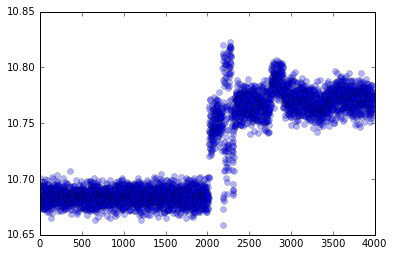

In [53]:
fig, ax = plt.subplots()
ax.plot(df['sweep_no'], df['tau'], 'o', alpha=0.3)

In [6]:
df.to_csv(folders[0] + '/analysis.csv')

# Analyse analysis.csv

In [23]:
# Get list of folders
folders = gb.glob("Data/*")
folders

['Data\\1464186005.67542', 'Data\\raw']

In [25]:
df = pd.read_csv(folders[0] + '/analysis.csv')

In [38]:
df.tail()

,Unnamed: 0,datetime,chip,concentration,fs,humidity,medium,sample_no,sweep_no,sweeps,tempC,timeID,tau
3984,3984,2016-05-25 16:05:00.772571,T16,NaN,0.0001,33.69,Water,1000,3985,10000,24.93,1.464186e+09,10.760092
3985,3985,2016-05-25 16:05:01.972640,T16,NaN,0.0001,33.66,Water,1000,3986,10000,24.94,1.464186e+09,10.782266
3986,3986,2016-05-25 16:05:03.177709,T16,NaN,0.0001,33.62,Water,1000,3987,10000,24.93,1.464186e+09,10.774869
3987,3987,2016-05-25 16:05:04.371777,T16,NaN,0.0001,33.62,Water,1000,3988,10000,24.94,1.464186e+09,10.763489
3988,3988,2016-05-25 16:05:05.581846,T16,NaN,0.0001,33.62,Water,1000,3989,10000,24.92,1.464186e+09,10.768387


In [29]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 13 columns):
Unnamed: 0       3989 non-null int64
datetime         3989 non-null datetime64[ns]
chip             3989 non-null object
concentration    0 non-null float64
fs               3989 non-null float64
humidity         3989 non-null float64
medium           3989 non-null object
sample_no        3989 non-null int64
sweep_no         3989 non-null int64
sweeps           3989 non-null int64
tempC            3989 non-null float64
timeID           3989 non-null float64
tau              3989 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(4), object(2)
memory usage: 405.2+ KB


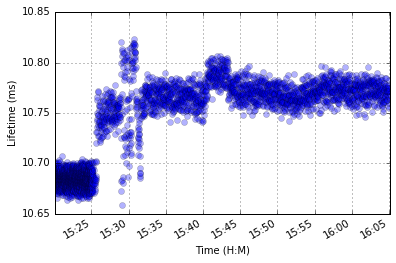

In [41]:
fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)
# ax.plot(df['datetime'], df['tempC'], '-')

# format the ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=np.arange(0,60,5)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 10)))

ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Time (H:M)')
plt.ylabel('Lifetime (ms)')
# plt.tight_layout()

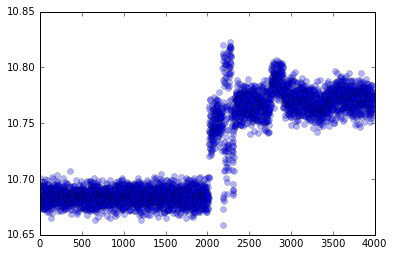

In [36]:
fig, ax = plt.subplots()
ax.plot(df['sweep_no'], df['tau'], 'o', alpha=0.3)

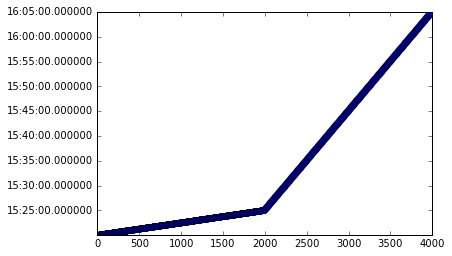

In [54]:
fig, ax = plt.subplots()
ax.plot( df['datetime'], 'o', alpha=0.3)